In [1]:
import os
import sys
from IPython.display import display
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

src_path = os.path.abspath(os.path.join('../src'))
if src_path not in sys.path:
    sys.path.append(src_path)
    
from utils.data import load_news, load_users
from evaluation.metrics import gs_score


In [2]:
MIND_VARIANT = "small"
EMBEDDINGS_FILE = "../embeddings.pickle"
MIN_HISTORY_LENGTH = 3

In [3]:
def add_news_embeddings(news, embeddings_file):
    with open(embeddings_file, "rb") as f:
        embeddings, topic_encoder = pickle.load(f)

    def encode(x):
        try:
            return topic_encoder.transform([x])[0]
        except:
            return None

    def embed(x):
        return embeddings[int(x)]

    news["encoded"] = news.subcategory.apply(encode)
    news = news.dropna().copy()
    news["embedding"] = news.encoded.apply(embed)
    return news


def get_embeddings_by_ids(ids, news):
    return np.array(news["embedding"][ids].values)


def compute_gs_scores(users, news):
    users["gs"] = (
        users["history"]
        .apply(lambda history: get_embeddings_by_ids(history, news))
        .apply(gs_score)
    )
    return users


In [4]:
users = load_users(MIND_VARIANT, data_dir="../data")
news = load_news(MIND_VARIANT, columns=["category", "subcategory"], data_dir="../data")
news_embeddings = add_news_embeddings(news, EMBEDDINGS_FILE)
users = compute_gs_scores(users, news_embeddings)

display(users["gs"].describe())

count    91935.000000
mean         0.611872
std          0.106156
min          0.281540
25%          0.538814
50%          0.588071
75%          0.658685
max          1.000000
Name: gs, dtype: float64

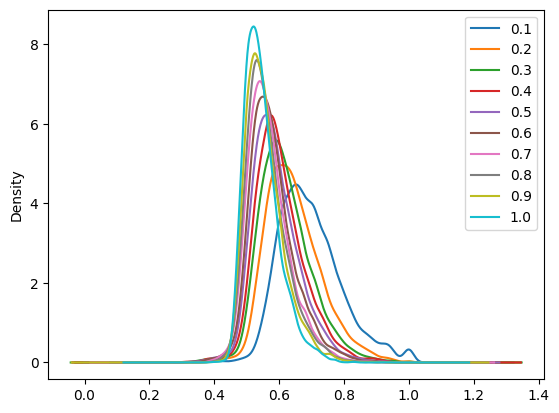

In [7]:
def plot_gs(users):
    users["history_length"] = users["history"].apply(len)
    users = users[users["history_length"] >= MIN_HISTORY_LENGTH].copy()
    users["percentile"] = pd.qcut(
        users.history_length, np.linspace(0, 1, 11), labels=np.arange(1, 11)/10
    )
    fig, ax = plt.subplots()
    for label, df in users.groupby("percentile"):
        df.gs.plot(kind="kde", ax=ax, label=label)
    plt.legend()
    plt.show()


plot_gs(users)